# Checkpoint 1: Neural networks and deep learning
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)

In this checkpoint exercise, we will use neural networks to predict the **type** of weather *given* the available ground observations. You will be using observation data from **June 2019** across all UK Met Office weather stations.

### Notes on the Dataset
* You will be using weather observation data from the UK Met Office Datapoint service
* Ground observations are made hourly at weather stations across the length of the UK 
* The data sample covers data from June 2019
* Data collections for each day starts at 6.30pm. All observation data is listed in one day blocks
* The time value column refers to the number of minutes after midnight 
* `Null` values for some features are expected (e.g. Wind Gust)
* Data import and preparation is already provided 


This week, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** Think of these as LEGO blocks; you have the ones you need but may look up how to "assemble" them.

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 9 October 2021** 
- This CP exercise sheet is divided into **6 sections**, corresponding to parts of the lecture, giving a maximum of **10 marks** in total:

| <p align='left'> Title                         | <p align='left'> Exercise nos. | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Conceptual questions               | <p align='left'>  1–5  | <p align='left'> 2.5 |
| <p align='left'> 2. Data preprocessing and RandomForest                | <p align='left'>  6–9  | <p align='left'> 2.5 |
| <p align='left'> 3. Neural networks in `scikit-learn`  | <p align='left'>  10–11 | <p align='left'> 1.5 | 
| <p align='left'> 4. Neural networks in `Keras`         | <p align='left'> 12–13 | <p align='left'> 2 |
| <p align='left'> 5. Regularisation                     | <p align='left'> 14–15 | <p align='left'> 1.5 |
| <p align='left'> 6. Bonus: Hyperparameter optimisation | <p align='left'> 16 | <p align='left'> 1.0 (\*bonus\*) |
| <p align='left'> **Total** | | <p align='left'> **10 + 1** |

- The total number of marks allocated for this CP is 10,
    - 1 additional mark can be given (maximimally up to 10 marks in total) for "bonus" exercise on hyperparameter optimisation. If you are pressed for time, focus on the first five sections; those are the core ones.
    - Half marks may be deducted for code legibility (i.e. very difficult to tell what you are doing), or for badly formated plots (i.e. no legends, axis labels etc.). The TAs will use their discression for this so comment code when applicable and keep relevant information in your plots.

_Note:_ You can suppress double-printing of plots from the `plot` module by either _(a)_ adding a semicolon after the function call (_i.e._ `plot.<method>(...);`), or _(b)_ by capturing the return `pyplot.Figure` object as a variable (_i.e._ `fig = plot.<method>(...)`).

## Preamble

In [1]:
# Standard import(s)
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# Suppress unnecessary ConvergenceWarnings and DeprecationWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Set a random seed variable to make workbook reproducible
seed=5
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

# Switch off multi-threading for TensorFlow
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\frame

In [2]:
# Load in the prepared weather data
obs = pd.read_csv('weather.csv')
obs.head()

,StationID,StationName,Elevation,Latitude,Longitude,Date,Time,Gust,Temperature,Visibility,WindDirection,WindSpeed,Pressure,PressureTrend,DewPoint,Humidity,Type
0,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1020,NaN,16.1,30000.0,E,8.0,1019.0,F,11.6,74.5,0
1,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1080,NaN,14.9,22000.0,E,8.0,1019.0,F,11.8,81.5,0
2,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1140,NaN,14.0,14000.0,E,6.0,1018.0,F,11.6,85.4,0
3,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1200,NaN,12.9,12000.0,ENE,2.0,1019.0,R,11.0,88.1,0
4,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1260,NaN,12.0,9000.0,E,2.0,1019.0,R,10.9,92.9,1


In [3]:
obs.shape

(106553, 17)

In [4]:
obs.describe()

,StationID,Elevation,Latitude,Longitude,Time,Gust,Temperature,Visibility,WindSpeed,Pressure,DewPoint,Humidity,Type
count,106553.000000,106553.000000,106553.000000,106553.000000,106553.000000,7703.000000,106442.000000,92662.000000,102060.000000,99530.000000,106402.000000,106397.000000,106553.00000
mean,6147.845636,114.466594,53.673022,-2.829034,702.914418,33.043749,14.958912,25698.164404,8.999510,1018.748337,10.348008,76.185240,0.99603
std,15821.503845,171.669120,2.466079,2.269594,412.057262,13.424855,4.294516,14263.873943,6.087882,6.327468,3.120565,17.208653,0.92971
min,3002.000000,2.000000,49.207900,-10.250000,0.000000,0.000000,-1.200000,20.000000,0.000000,976.000000,-28.200000,0.800000,0.00000
25%,3204.000000,20.000000,51.565000,-4.149000,360.000000,29.000000,12.000000,14000.000000,5.000000,1015.000000,8.400000,65.300000,0.00000
50%,3414.000000,65.000000,53.175000,-2.663000,720.000000,32.000000,14.500000,25000.000000,8.000000,1018.000000,10.500000,79.200000,1.00000
75%,3769.000000,132.000000,55.285000,-1.097000,1020.000000,39.000000,17.500000,35000.000000,11.000000,1024.000000,12.500000,90.000000,1.00000
max,99142.000000,1245.000000,60.749000,1.348000,1380.000000,105.000000,31.600000,75000.000000,81.000000,1036.000000,22.700000,100.000000,3.00000


For this exercise we will use **8** input features (provided) and clean the data:

In [5]:
# Define 8 input feature variables, 1 target variable data, and names of the 3 weather types
features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
output   = ['Type']
wtype    = ['Clear', 'Cloudy', 'Precip']

Define derived dataset containing only the relevant columns and rows.

In [6]:
# Reduce to feature and type columns
dataset = obs[features + output]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Drop unrecorded weather type
dataset = dataset[dataset.Type != 3]

# Check shape 
dataset.shape

(86313, 9)

## 1. Conceptual questions (2.5 Marks)
---
This section covers **5** exercises on conceptual understanding of neural networks.

#### 1. Which are the most used activation functions and why do we (typically) need non-linear activation functions in neural networks? (0.5 mark)

The most used activation functions are Sigmoid Activation which has a range from $0\longrightarrow1$,ReLU which has a range from $0\longrightarrow\infty$, Softmax which also has a range from $0\longrightarrow\infty$ but a shallower curve upwards, and tanh which has a range from $-1\longrightarrow1$.

Non-linear activation functions are required because hidden layers require non-linear functions in order to operate via backpropagation as the derivative of a linear function is a constant unrelated to the input (so you can't see which weights give better predictions). If they were linear, then merely a linear transformation would occur between the input and output which would make the hidden layers redundant. 


#### 2. Why do we need deep neural networks and which are the main differences between deep and shallow learning? (0.5 Mark)

A deep neural network typically has at least two or more hidden layers. A deep neural network doesn't just learn to predict an output given an input but it's able to understand basic features of the input. It can figure out the most important features (e.g. a cat has whiskers which is a more important feature than fur to differentiate between images of cats and dogs) and use that to make a more informed decision for the output.
 
The difference between deep and shallow learning is that shallow learning requires the features to be manually selected whereas deep learning can select features for itself. Deep learning can take high dimensional data, automatically extract the features and run it through a deep combination at the same time. Shallow learning requires the high dimensional data to be converted to low dimensional data with the features pointed out before being fed through a shallow combination.

#### 3. Discuss the Bias-variance trade-off and its relation to underfitting and overfitting of a model. Which are the caractheristics of an ideal model?  (0.5 mark)

A high bias is a feature of underfitting as the higher the bias value of a model, the more relations between features and output will be missed.

The variance, on the other hand, is a feature of overfitting as the higher the variance, the greater the sensitivity an output has to a feature. Thus, random noise from the training data can be taken into the model.

Since we don't want to overfit or underfit, we must keep both these values at a minimum. Therefore, a bias-variance trade off must be created where we keep training the model to decrease the bias but don't train it too much so that the variance doesn't increase too much.

The characteristics of an ideal model are a low bias and a low variance.

#### 4. Given a neural network with 4 input nodes, 2 layers with 5 nodes each, and 1 output node, what is the total number of free (trainable) parameters in the network? Does it matter which activation function(s) are used?  (0.5 mark)

The input nodes each have 5 synapses attached to the first layer of hidden nodes. The nodes also count as free parameters as they have a bias so we need to add them to the total. Furthermore, we have 5 synapses coming out of each node on the first layer that connect to the 5 nodes on layer 2. Finally, each of these nodes have one synapse attached to the output node which, too, is a trainable parameter so should also be added to the list. Therefore, we have

$$(4\times5)+5+(5\times5)+5+1=56$$

The activation function used does matter for a neural network. For one output node, we'll often use a sigmoid (if network is use for binary classification), linear or a ReLU (for regressions) activation function. For a deep hidden layer of this type (multilayer perceptron), we'll typically use a ReLU activation function.

#### 5. What are appropriate choice for _(a)_ the number of output nodes and _(b)_ output activation function(s) for each of the following tasks, and why? (0.5 mark)

1. Regression of the $x$, $y$, and $z$ coordinates of a single particle in an arbitrary coordinate system
2. Regression of particle energy of a single particle
3. Classification of two processes (signal vs. background)
4. Classification among *N* classes (dog vs. cat vs. fish vs. ...)

1.) We want 3 output nodes, one for each coordinate x, y & z. The output activation function we want is the ReLU function but the coordinate system must be defined such that the particle position is always positive as ReLU cannot regress negative quantities. However, a linear activation function can also be used as the regressi

2.) We want 1 output node, the energy of the single particle. Given that energy cannot become negative, we can use ReLU again to regress the values.

3.) We want 1 output node. Since we have a binary classification, we need to use the Sigmoid activation function.

4.) We want N output nodes, one for each class. Now we have a multiclass classification so we want to use the Softmax activation function.

## 2. Data preprocessing and RTs (2.5 mark)
---
This section covers **4** exercises on data preparation, feature standardisation, and dataset splitting.

In [7]:
# Relevant import(s) for this section
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

---
**_Comment on target format and one-hot encoding:_** By default, the target column (`Type`) contains one integer (0, 1, or 2) for each example, the integer specifying one of three possible types of weather. However, for doing multi-class classification (which this is), we want our neural network to have one output node per class (_i.e._ 3 output nodes in this case), such that the activation of each output node is interpreted as the likelihood for a given sample being of the type in question. Therefore, the target should also be a 3-element vector for each sample; this vector should be all zeros, except for a $1$ at the index corresponding to the type in question. This is called **one-hot encoding**, and a few examples are shown below:

- type = 0 $\to$ one-hot = $[1, 0, 0]$ for 3 classes
- type = 1 $\to$ one-hot = $[0, 1, 0]$ for 3 classes
- type = 2 $\to$ one-hot = $[0, 0, 1]$ for 3 classes

This is the target towards which a neural network classifier is trained: That is, ideally, for an example of type 0, the network will output a large activation ($\approx 1$) on the first output node (interpreted as a large likelihood for the first weather type), and very small activations ($\ll 1$) on the two other output nodes (intepreted as small likelihoods for the two other weather types); and so on.

The same type of one-hot encoding can be performed for any number of target classes $N_{c}$, which just results in $N_{c}$-element target vectors with a single non-zero entry each.

To be user friendly, however, `scikit-learn` allows us to use integer targets for multi-class classification — it does the one-hot encoding for us "under the hood." Similarly, `keras`, _can_ also allow us to use integer targets for multi-class classification, provided we use the appropropriate loss (`sparse_categorical_crossentropy`). Otherwise (if we use `categorical_crossentropy` loss), it expects one-hot encoded targets. Which approach you choose is up to you — but now you know what goes on.

---

#### 6. Prepare the feature and target arrays (0.5 mark)
- Randomly sample **3,500** observations per weather type (**10,500** observations in total) from `dataset` into a new `pandas.DataFrame`; call it `sample`.
- One-hot encode the **wind direction** variable (_i.e._ $N$ to $[1, 0, \ldots, 0]$, $NNE$ to $[0, 1, \ldots, 0]$, _etc._ ), to allow us to input it to the neural network. The exact order of the encoding (_i.e._ which direction corresponds to which index) doesn't matter. *Hint:*
  - *Either:* Use the scikit-learn `ColumnTransformer` with the `OneHotEncoder` applied to the `WindDirection` column, and let the remainder of the features pass through un-transformed.
  - *Or:* Use the `OneHotEncoder` class directly on the `WindDirection` column (use `sparse=False` in the `OneHotEncoder` constructor), and then concatenate with a `numpy.array` containing the remaining features.
- Define `numpy.arrays` named `X` and `y` containing the training features (the 7 unmodified ones plus the one-hot encoded wind directions) and target, respectively.
- Argue whether the shapes of `X` and `y` are as expected/as they should be.

In [8]:
#Concatenate 3 dataframes with randomly sampled data for different weather types
sample = pd.concat([dataset[dataset['Type']==0].sample(3500),
                    dataset[dataset['Type']==1].sample(3500),
                    dataset[dataset['Type']==2].sample(3500)])




#define a column transformer that will encode the wind direction and pass through all other data
ct = ColumnTransformer([('encoder',OneHotEncoder(),['WindDirection'])],remainder='passthrough')

#Define X as required by dropping the type and applying the column transformer defined above
#Define y as the target which, in our case, is the Type
y = np.asarray(sample.Type)
X = ct.fit_transform(sample.drop('Type',axis=1))

print("The shape of y = "+str(y.shape))
print("The shape of X = "+str(X.shape))

print(X[0])

#Observe the first row of X printed below.
#You can see the last 7 columns are numbers and the first 16 appear to be a-
#bunch of 0s and a single 1. The 1 represents the direction of wind for -
#this particular row.
#In the classification system of wind directions, there are 16 different directions-
#each one representing 1/16 of the compass circle.
#Thus with 7 columns of normal data along with 16 hot encoded directions add up-
#to 23. Thus, the shape of X is not unusual.
#The shape of y is also not unusual as it has one column of 10,500 values --
#The same number of values per column as X.

The shape of y = (10500,)
The shape of X = (10500, 23)
[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 5.51604e+01 6.00000e+00
 2.09000e+01 3.50000e+04 1.00000e+01 1.02700e+03 5.64000e+01]


#### 7. Train a Random Forest and evaluate the performance (1 mark)

Decision trees work well with a mixture of features (of different scales, and bot binary and continuos), so we will train a random forest to do the job of categorisation.

You are given the train test split:

In [9]:
#Import random fosets and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape)

(7350, 23) (3150, 23)


1. Train a RandomForestClassifier with 1000 estimators, `gini` seperation criteria, and max depth 4.
2. Check the overal accuaracy on the testing set

3. Use the confusion_matrix method to return the confusion matrix normalised over the true lables, i.e. sum over rows should sum to 100%. Use the given colormap to plot the confusion matrix in a heatmap.
    - Define the axis tick names to represent Clear, Cloudy or Precip
    - Use suitable x and y axis labels
    
4. What are the true positive rates for clear, cloudy and perp? What is the probability that rain is forcast given that the day is clear?
5. Which features does the random forest deem the most important?

In [10]:
#Questions 1 & 2

#Define a random forest and print the accuracy of the predictions
forest = RandomForestClassifier(n_estimators=1000, max_depth=4,criterion='gini')
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


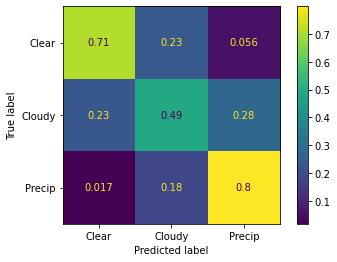

In [11]:
#Question 3

#Define the confusion matrix and normalise it so that each row/column sums to 1
cmat = confusion_matrix(y_test,y_pred,normalize='true')
#dispay the matrix and redefine the display labels to show the weather type
cmatplot = ConfusionMatrixDisplay(confusion_matrix=cmat,display_labels=wtype)

cmatplot.plot()
plt.show()

Question 4.)

The confusion matrix shows that the true rates of clear, cloudy and precipitation are equal to 71%, 49% and 80%, respectively. Furthermore, the probability of it being clear (true label) when rain is forecast (predicted label) is shown to be equal to 0.055 or 5.5%. 

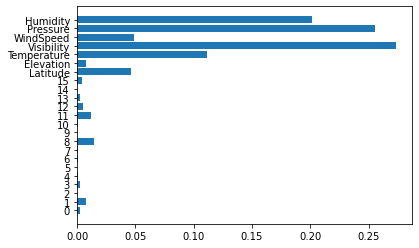

In [12]:
#Question 5

# Given plotting example for feature importance
plt.barh(range(23), forest.feature_importances_)
plt.yticks(range(23), list(range(16))+features[:-1])
plt.show()

#The most important features are Visibility, Pressure and Humidity.

#### 8. Standardise the relevant features (0.5 mark)

_Note:_ You shouldn't standardise the one-hot encoded wind directions; they already have the desired format. Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
- Hint:

    - Use the scikit-learn `StandardScaler`
    - Or use the scikit-learn `MinMaxScaler`

- Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - The number of columns should match, and depending on the choice of standardisation, the last 7 columns should either have:
      - (Using `StandardScaler`) means = 0 and standard deviations = 1; or
      - (Using `MinMaxScaler`) min = 0, max = 1

In [13]:
scaler = StandardScaler()
scaled = scaler.fit_transform(sample.drop(['Type','WindDirection'],axis=1))

print("The mean values are: "+str(np.mean(scaled,axis=0))) #This is close enough to 0 (likely a float error)
print("")
print("The std deviations are: "+str(np.std(scaled,axis=0))) #These are all equal to 1, as required

#Now to add the wind direction back into the data
scaled_data = np.concatenate([X[:,0:16],scaled],axis=1)

The mean values are: [-1.67823427e-15 -5.95502483e-17 -9.74458609e-17  2.16546358e-17
 -9.74458609e-17  2.92337583e-15 -2.16546358e-17]

The std deviations are: [1. 1. 1. 1. 1. 1. 1.]


#### 9. Split the dataset into a training and a testing part (0.5)

Reserve **30%** of data for testing. Check whether the resulting arrays have the expected shapes.

In [14]:
x2_train, x2_test, y2_train, y2_test = train_test_split(scaled_data, y, test_size=0.3,
                                                        random_state=1) # 70% training and 30% test

print(x2_train.shape,x2_test.shape)

#This is the same shape as before so the shapes are okay!

(7350, 23) (3150, 23)


## 3. Neural networks in `scikit-learn` (1.5 mark)
---
This section covers **2** exercises on constructing and training neural networks using the `scikit-learn` library, as well as evaluating neural network performance. `scikit-learn` provide many, very easy to use ML algorithms, including neural networks. These are called `MLPClassifier` (MLP = multi-layer perceptron; a historic name for densely connected, feed-forward neural networks) when used for classification, and `MLPRegressor` when used for regression. We will focus on the former for now.

In [15]:
# Relevant import(s) for this section
from sklearn.neural_network import MLPClassifier


#### 10. Construct and train a neural network  (1 mark)

- Create an `MLPClassifier` which
    - has **1 hidden layer of 50 neurons** 
    - has **no regularization term**
    - trains for a maximum of **100 epochs** 
    - uses a batch size of **32**
- Fit the classifier using the standard `.fit()` member method.
- Plot the loss function value as a function of number of epochs (0.5 of mark).
  You can access the loss history through the `.loss_curve_` attribute of the `MLPClassifier` instance. 

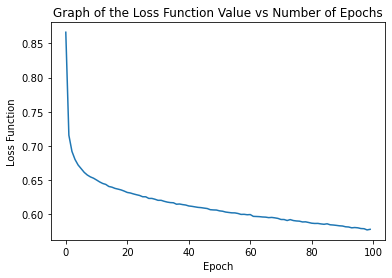

In [16]:
mlp = MLPClassifier(max_iter=100,alpha=0,hidden_layer_sizes=(50,),batch_size=32)

mlp.fit(x2_train,y2_train)

#Plotting a graph of the loss function
plt.plot(mlp.loss_curve_)
plt.title("Graph of the Loss Function Value vs Number of Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss Function")
plt.show()

#### 11. Performance evaluation (0.5 mark)

- Using the testing dataset: 
    - Compute the overall accuracy for the classifier using the `MLPClassifier`'s `.score()` member method for both testing and training datasets.
    - Compute the confusion matrix (normalised in true labels), and plot it 
- Discuss the results

The training score is: 0.7485714285714286
The testing score is: 0.7006349206349206


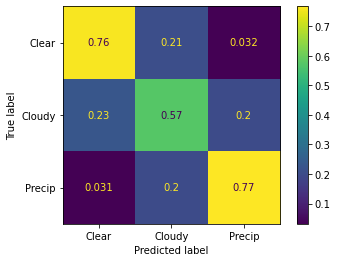

In [17]:
print('The training score is: '+str(mlp.score(x2_train,y2_train)))
print('The testing score is: '+str(mlp.score(x2_test,y2_test)))

y2_pred = mlp.predict(x2_test)

#Define the confusion matrix and normalise it so that each row/column sums to 1
cmat2 = confusion_matrix(y2_test,y2_pred,normalize='true')
#dispay the matrix and redefine the display labels to show the weather type
cmatplot2 = ConfusionMatrixDisplay(confusion_matrix=cmat2,display_labels=wtype)

cmatplot2.plot()
plt.show()

We can see that the accuracy is superior for the neural network (\~75% for the training dataset) than for the random forest (\~67%). In fact, the confusion matrix supports this as the probability on the diagonal is closer to 1 here than on the random forest and the off-diagonals are closer to 0 here too. 

Also, the training set has a higher accuracy than the testing dataset. This is to be expected, however, as the model is optimised for the training dataset so its accuracy will always be greater than or (eventually) equal to the testing dataset. 

## 4. Neural networks in `Keras` (2 marks)
---
This section covers **2** exercises on constructing and training neural networks using the `Keras` library. `scikit-learn` is very easy to use, but libraries like `Keras` provide a lot more flexibility, which is why we will be using these extensively in the last two units of the _'Data science tools and machine learning'_ track.

In [18]:
# Relevant import(s) for this section
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

#### 12. Construct a neural network in `Keras` (1 mark)

- Create a `keras.Model` using the **Keras functional API**. The network should have:
    - An input layer with the same number of nodes as the number of features in `X`.
    - A single, densely connected hidden layer with **50 nodes** equipped with **ReLU activation**.
    - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
- Compile the model the using the **Adam optimiser**, add `'accuracy'` as metric, and use either:
    - `categorical_crossentropy` loss, if you have one-hot encoded the targets `y`, or
    - `sparse_categorical_crossentropy` loss if you hare using integer-valued targets.
- Use the `.summary()` member method to print an overview of the model you have created, explain the output.

In [19]:
#Defining the neural network 
inputs = Input(shape=(X.shape[1],))
x = Dense(50,activation='relu')(inputs)
outputs = Dense(3,activation='softmax')(x)
#Creating the model
model = Model(inputs,outputs)

#Compiling the model with adam optimizer and accuracy as the metric.
#Also, since y are just integer values from 0-2, we use sparse_categorical_crossentropy
#for the loss function
model.compile(optimizer='Adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


The output shows that we expect an input with 23 columns and an N number of rows (doesn't matter how many, thankfully). Input nodes have neither a bias nor a weight, thus there are no parameters attached to the input layer. The hidden layer, named dense, however, has 1200 parameters. The reason being that each input has one weighted synapse attached to each node so we have 23x50=1150 parameters. On top of that, each node in the hidden layer has a bias which, too, is defined as a trainable parameter. With 50 nodes, we have 1150+50=1200 parameters; as required.

In the output layer, there are 3 nodes with 153 parameters. For the same reason as above, each of the 50 hidden layer nodes have 3 synapses connected to each output node thus we have 50x3=150 paramters. Add on the 3 bias parameters for the output nodes gives us 150+3=153 trainable parameters. Again, this is what we observe so everything makes sense!

#### 13. Train a `Keras` neural network (1 mark)

- Use the `.fit()` member method to train the network on the **training dataset** for **100 epochs** with a **batch size of 32**. Use **20% of the data for validation** and make sure to have `Keras` **shuffle** the training data between epochs. Save the fit history by doing `history_mld = .....`
- Print the classification accuracy using the `.evaluate()` member method, for both the training and testing dataset. Comment on the results.
- Plot val_loss and loss functions from the fit history. On the same plot, plot the sklearn curve from the excercise above. Note the sklearn NN does not provide a complementary validation loss history, so only plot the training loss.
- Comment on the results of the overall accuracy compared to the scikit-learn method.

In [20]:
#fitting the model to the data

history_mld = model.fit(x=x2_train,y=y2_train,batch_size=32,epochs=100,validation_split=0.2,shuffle=True)

Train on 5880 samples, validate on 1470 samples
Epoch 1/100
5880/5880 [==============================] - 0s 81us/sample - loss: 0.8841 - acc: 0.5697 - val_loss: 0.7264 - val_acc: 0.6871
Epoch 2/100
5880/5880 [==============================] - 0s 45us/sample - loss: 0.7354 - acc: 0.6643 - val_loss: 0.6783 - val_acc: 0.7020
Epoch 3/100
5880/5880 [==============================] - 0s 50us/sample - loss: 0.7075 - acc: 0.6794 - val_loss: 0.6644 - val_acc: 0.7068
Epoch 4/100
5880/5880 [==============================] - 0s 47us/sample - loss: 0.6926 - acc: 0.6835 - val_loss: 0.6615 - val_acc: 0.7054
Epoch 5/100
5880/5880 [==============================] - 0s 50us/sample - loss: 0.6842 - acc: 0.6857 - val_loss: 0.6553 - val_acc: 0.7163
Epoch 6/100
5880/5880 [==============================] - 0s 52us/sample - loss: 0.6787 - acc: 0.6861 - val_loss: 0.6572 - val_acc: 0.7034
Epoch 7/100
5880/5880 [==============================] - 0s 50us/sample - loss: 0.6740 - acc: 0.6878 - val_loss: 0.6527 - va

5880/5880 [==============================] - 0s 47us/sample - loss: 0.6030 - acc: 0.7310 - val_loss: 0.6447 - val_acc: 0.7102
Epoch 60/100
5880/5880 [==============================] - 0s 47us/sample - loss: 0.6021 - acc: 0.7330 - val_loss: 0.6454 - val_acc: 0.7109
Epoch 61/100
5880/5880 [==============================] - 0s 45us/sample - loss: 0.6016 - acc: 0.7345 - val_loss: 0.6474 - val_acc: 0.7116
Epoch 62/100
5880/5880 [==============================] - 0s 47us/sample - loss: 0.5998 - acc: 0.7330 - val_loss: 0.6452 - val_acc: 0.7218
Epoch 63/100
5880/5880 [==============================] - 0s 45us/sample - loss: 0.6002 - acc: 0.7349 - val_loss: 0.6487 - val_acc: 0.7075
Epoch 64/100
5880/5880 [==============================] - 0s 49us/sample - loss: 0.5987 - acc: 0.7359 - val_loss: 0.6444 - val_acc: 0.7211
Epoch 65/100
5880/5880 [==============================] - 0s 45us/sample - loss: 0.5978 - acc: 0.7357 - val_loss: 0.6470 - val_acc: 0.7156
Epoch 66/100
5880/5880 [================

In [21]:
train_loss_v,train_metric_v = model.evaluate(x=x2_train,y=y2_train,batch_size=32,verbose=0)
test_loss_v,test_metric_v = model.evaluate(x=x2_test,y=y2_test,batch_size=32,verbose=0)

print("For the training data set, we get a loss value of: "+str(train_loss_v))
print("For the testing data set, we get a loss value of: "+str(test_loss_v))
print("")
print("For the training data set, we get a metric value of: "+str(train_metric_v))
print("For the testing data set, we get a metric value of: "+str(test_metric_v))

For the training data set, we get a loss value of: 0.5897887886786948
For the testing data set, we get a loss value of: 0.6756476867009723

For the training data set, we get a metric value of: 0.73755103
For the testing data set, we get a metric value of: 0.69555557


The training data set is superior to the testing one as it has a lower loss value.

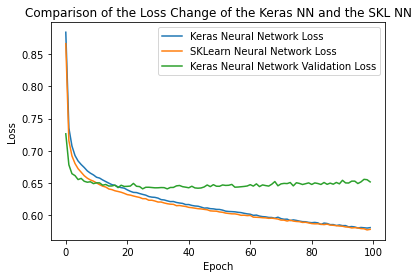

In [22]:
loss_function=history_mld.history['loss']
loss_val=history_mld.history['val_loss']

plt.plot(loss_function,label='Keras Neural Network Loss')
plt.plot(mlp.loss_curve_,label='SKLearn Neural Network Loss')
plt.plot(loss_val,label='Keras Neural Network Validation Loss')
plt.title("Comparison of the Loss Change of the Keras NN and the SKL NN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

We can see from the graph that the keras neural network and the SKLearn network are pretty much the same with regards to the loss function. SKLearn decreases loss a little faster than Keras but Keras makes up for it at the end. The only issue with the SKLearn data is that we can't see the validation loss but we do know from the Keras data that its validation loss does start to increase at epochs above 40. Therefore, I assume SKLearn also has an increasing validation loss but it is impossible to tell if its greater than Keras or not. What we do know, however, is that Keras the validation loss doesn't increase that fast.

## 5. Regularisation (1.5 marks)
---
This section covers **2** exercises on the impact of weight regularisaton. Note that $L_{1}$- and $L_{2}$-regularisation may also be applied to the activation of intermediate layers. Also, a similar regularising effect could be achieved using **dropout** regularisation, which you are encouraged to try out, but which we won't study in this CP exercise.

In [23]:
# Relevant import(s) for this section
from tensorflow.python.keras.regularizers import l1_l2

#### 14. Define `Keras` model factory method (0.5 mark)

- Define a python function called `big_model_fn` which takes the followng three arguments:
    - `l1`: A float specifying the $L_{1}$ regularisation factor (default value: 0)
    - `l2`: A float specifying the $L_{2}$ regularisation factor (default value: 0)
    - `name`: A string, specifying the name of the model (default value: None)
- Indside the function, you should:
    - Construct a `Keras` model using the functional API, which has:
        - An input layer with the same number of nodes as the number of features in `X`.
        - **Two** densely connected hidden layer with **100 nodes** each, both equipped with **ReLU activation**.
        - Both hidden layers should be subject to kernel regularisation (_i.e._ weight regularisation) with the regularisation factors specified as an input.
        - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
        - A name given by the corresponding argument.
    - Compile the model in the same way as in **Exercise 14.**
- The function should return the compiled `Keras` model. 

The method will provide a convenient way of constructing and compiling a number of "big"/deep `Keras` models which differ only by their regularisation and name.

In [24]:
def big_model_fn(l1=0,l2=0,name=None):
    inputs = Input(shape=(X.shape[1],))
    x = Dense(100,activation='relu',kernel_regularizer=l1_l2(l1,l2))(inputs)
    y = Dense(100,activation='relu',kernel_regularizer=l1_l2(l1,l2))(x)
    outputs = Dense(3,activation='softmax')(y)
    #Creating the model
    model = Model(inputs,outputs,name=name)
    model.compile(optimizer='Adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

#### 15. Train "big" models with and without regularisation (1 mark)

- Construct three "big" model using the factory method:
     - One with default parameters
     - One with `l1=0.0003` and  `name='Big model (L1-regularised)'`
     - One with `l2=0.003`  and `name='Big model (L2-regularised)'`
- Train each one as in **Exercise 15.**
- Compare first the loss history of the un-regularised "big" model to that of the small model from **Exercise 15** using the `plot.loss()` method.
- Then, compare the loss histories of all three "big" models with that of the small model.
- Plot the loss and val loss of all 4 models and discuss the results. Target these points:
    - Compare the performance of deep vs shallow models on the testing sets
    - Compare the level of ovetraining (training vs testing loss)
    - Note: Don't be alarmed if the shallow network performs slightly better that the deeper ones, this is dataset dependant.

In [25]:
#1 Constructing the three big models

default_model = big_model_fn()
l1_big_model = big_model_fn(0.0003,0,'Big model (L1-regularised)')
l2_big_model = big_model_fn(0,0.003,'Big model (L2-regularised)') 

In [26]:
#2 Training the models

def_his = default_model.fit(x=x2_train,y=y2_train,batch_size=32,epochs=100,validation_split=0.2,shuffle=True,verbose=0)
l1_his = l1_big_model.fit(x=x2_train,y=y2_train,batch_size=32,epochs=100,validation_split=0.2,shuffle=True,verbose=0)
l2_his = l2_big_model.fit(x=x2_train,y=y2_train,batch_size=32,epochs=100,validation_split=0.2,shuffle=True,verbose=0)

In [27]:
#3 Evaluating the models

def_loss=def_his.history['loss']
def_val=def_his.history['val_loss']

l1_loss=l1_his.history['loss']
l1_val=l1_his.history['val_loss']

l2_loss=l2_his.history['loss']
l2_val=l2_his.history['val_loss']

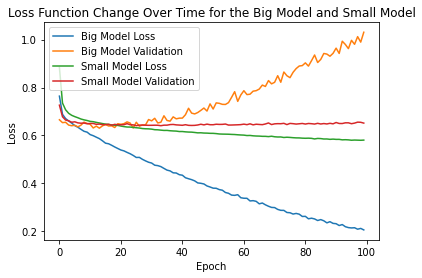

In [28]:
#comparing default big loss model with small loss model

small_loss=history_mld.history['loss']
small_val=history_mld.history['val_loss']

plt.plot(def_loss,label='Big Model Loss')
plt.plot(def_val,label='Big Model Validation')
plt.plot(small_loss,label='Small Model Loss')
plt.plot(small_val,label='Small Model Validation')
plt.title('Loss Function Change Over Time for the Big Model and Small Model')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

From this graph, we see that deep neural network loss goes down far faster and further than the shallow neural network although the validation loss goes up astronomically. Thus, the deep network starts to overfit the data after about 10 epochs whilst the shallow network doesn't overfit that badly at all.   

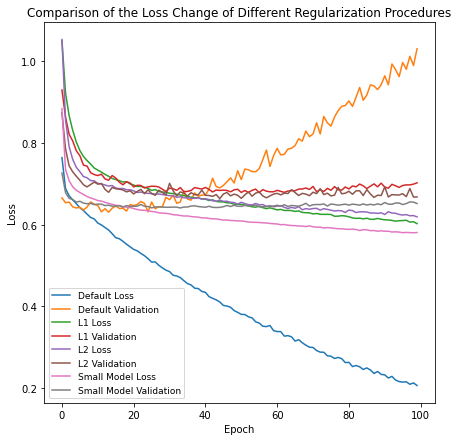

In [34]:
#plotting the loss of the three big models
plt.plot(def_loss,label='Default Loss')
plt.plot(def_val,label='Default Validation')
plt.plot(l1_loss,label='L1 Loss')
plt.plot(l1_val,label='L1 Validation')
plt.plot(l2_loss,label='L2 Loss')
plt.plot(l2_val,label='L2 Validation')
plt.plot(small_loss,label='Small Model Loss')
plt.plot(small_val,label='Small Model Validation')
plt.rcParams["figure.figsize"] = (7,7)
plt.title("Comparison of the Loss Change of Different Regularization Procedures")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(prop={'size': 9})
plt.show()

We can see from this graph that the loss function of the default parameters (no regularization) goes down very fast but the validation loss shoots upward even faster. Thus, we obtain an unreasonable amount of overfitting as it's completely unregularized. The l1 and l2 are much better in terms of overfitting but they don't decrease the loss function as quickly as the default curve. In this case, the l2 regularization is better at keeping the validation low but the not quite as good as keeping the bias low whereas for l1 regularization, the opposite holds. 

Nevertheless, the regularized neural networks are very effective at preventing overfitting. 

The small model loss is also very good -- better, in fact -- although this is due to the dataset. It's the best out of them all which means that it's better to have a shallow neural network than an unregularized deep neural network.

## 6. Bonus: Hyperparameter optimisation (1\*bonus\* mark)
---

This section covers **1** exercise on the on hyperparameter optimisation. 

In [30]:
# Relevant import(s) for this section
from sklearn.model_selection import GridSearchCV, cross_val_score

---
_**Comment on simplified hyperparameter optimisation example:**_ You will try to perform a simple optimisation using a grid search

For convenience, we will be using the `scikit-learn` `MLPClassifier` as our base class, but the same principles apply to just about any ML model constructed in any framework. Just as in the examples in the lecture, we will restrict the hyperparameter space to just two dimensions:

* the number of hidden layers, `nb_layers`, and
* the number of nodes per hidden layer, `nb_nodes_per_layer`, which is taken to be the same for all hidden layers for simplicity.

Since the `scikit-learn` neural network classifier class doesn't support these two hyperparameters by default, provided is a simple wrapper class, that works exactly like `MLPClassifier`, it just takes the two parameters above as arguments in the constructor. Don't worry about understanding it in detail. This allows us to call 

In [31]:
class MLPClassifierWrapper(MLPClassifier):
    """
    Wrapper around `sklearn.neural_network.MLPClassifier` with a convenient set 
    of properties (nb_layers and nb_nodes_per_layer) suitable for hyperparameter 
    optimisation exercises.
    
    Arguments:
        nb_layers: Integer, number of hidden layers
        nb_nodes_per_layer: Number of nodes per hidden layer, taken to be the 
            same for all for convenience.
    """

    def __init__ (self, nb_layers=1, nb_nodes_per_layer=100, **kwargs):
        
        # Member variables
        self._nb_layers = nb_layers
        self._nb_nodes_per_layer = nb_nodes_per_layer  
        
        # Call base class (`MLPClassifier`) constructor
        super(MLPClassifierWrapper, self).__init__(**kwargs)
        
        # Trigger `_set_architecture`
        self._set_architecture()
        return

    @property
    def nb_layers(self):
        return self._nb_layers
    
    @property
    def nb_nodes_per_layer(self):
        return self._nb_nodes_per_layer 

    @nb_layers.setter
    def nb_layers(self, value):
        self._nb_layers = value
        self._set_architecture()
        return
    
    @nb_nodes_per_layer.setter
    def nb_nodes_per_layer(self, value):
        self._nb_nodes_per_layer = value
        self._set_architecture()
        return
    
    def _set_architecture (self):
        """
        Sets the `hidden_layer_sizes` parameter of the base `MLPClassifier` 
        class, based on the two custom parameters we have chosen.
        """
        
        self.hidden_layer_sizes = tuple([self._nb_nodes_per_layer for _ in range(self._nb_layers)])
        return
    pass

---

#### 16. Perform a grid search (1 mark)

- Construct a python `dict` called `param_grid` which specifies the hyperparameter configurations to try for each parameter dimension. That is, it should have
    - `"nb_layers"` and `"nb_nodes_per_layer"` as keys, and
    - lists of integers as values, corresponding to the values of each parameter you want to try out (_e.g._ [1, 2, ...])
- Choose a reasonable set of values for each parameter; about a handful for each.
- Use the `GridSearchCV` class to perform _**3**_**-fold** cross validation (CV) optimisation of the validation **accuracy**
    - Hint: You can use the `n_jobs=...` argument to enable multi-processing, thereby speeding up the optimisation, at the expense of reproducibility.
- The base classifier should be an instance of `MLPClassifierWrapper` set to train for **100 epochs**.
- Present the results:
    - Print the best parameter configuration found. GridSearchCV has a public member which stores this. Read doc.
    - Print the mean and standard deviation of the test scores for the best configuration found. (_Hint:_ These can be found in the `.cv_results_` attribute)
    - Plot the optimisation results using the `plot.optimisation` method.
- Discuss the results. What would happen if the best result is foundon the edge of the parameter grid?